<a href="https://colab.research.google.com/github/rofranklin/dataminingfinalproject/blob/master/FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

For my final project, I used the Microsoft Malware Prediction Dataset and worked on trying to get a better score on the private leaderboard. 
The things I struggled with were:
- The data!
  - The quantity of data
  - The sampling of the data - the train and test data were separated by time and how that affects the sampling for malware
  - the quality of data - many columns were mostly empty
  
  Processing the data - lots of feature exploration! but SO many rows! 4gb worth of train/test data
  
  keys to managing that - the sample set was determined to be random as stated in the project details so we needed to take a representative sampling
  
  utilized light gbm
  - this is in essence a binary classifcation problem so gbm is a little bit of overkill, however effective
  - utilized all features at first but accuracy was limited and resource constraints are an issue!
  
  - now utlizing an even smaller set of features
  
  
 So the data in itself is interesting, but also the application of finding the probablility that a machine is infected with malware! The most pertinent real life appliation relates to a project that is actively being worked on in security where, given company data and a google data set

In [0]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth

auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


import kaggle

Download 100%.


In [0]:
!kaggle competitions download -c microsoft-malware-prediction --force

 93% 125M/134M [00:02<00:00, 58.6MB/s]
100% 134M/134M [00:02<00:00, 64.9MB/s]
100% 643M/643M [00:14<00:00, 44.3MB/s]
100% 643M/643M [00:14<00:00, 46.6MB/s]
 98% 721M/735M [00:13<00:00, 45.2MB/s]
100% 735M/735M [00:13<00:00, 55.6MB/s]


First attempt based on https://www.kaggle.com/cdeotte/private-leaderboard-0-750/data

and uses stuff from 
https://www.kaggle.com/cdeotte/time-series-eda-malware-0-64

In [0]:
import pandas as pd, numpy as np, os, gc
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta
import calendar, math
import matplotlib.pyplot as plt


In [0]:
# Lower detection rate for August and September computers
AdjustPublicScore = True
# 0=No, 1=Remove Nov 20,21,22,23,24,25, 2=Downward trend Nov 20,21,22,23,24,25
AdjustPrivateScore = 2

dtypes = {}
dtypes['MachineIdentifier'] = 'str'
dtypes['AvSigVersion'] = 'category'
dtypes['HasDetections'] = 'int8'


In [0]:
# LOAD TRAIN DATA
df_train = pd.read_csv('/content/train.csv.zip', usecols=list(dtypes.keys()), dtype=dtypes)
print ('Loaded',len(df_train),'rows of train.CSV!')

Loaded 8921483 rows of train.CSV!


In [0]:
df_test = pd.read_csv('/content/test.csv.zip', usecols=list(dtypes.keys())[0:-1], dtype=dtypes)
print ('Loaded',len(df_test),'rows of test.CSV!')

Loaded 7853253 rows of test.CSV!


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df_test2 = pd.read_csv('/content/drive/My Drive/super_blend.csv')
print ('Loaded',len(df_test),'rows of super_blend.csv!')

Loaded 7853253 rows of super_blend.csv!


In [0]:
datedictAS = np.load('/content/drive/My Drive/AvSigVersionTimestamps.npy')[()]
df_test['Date'] = df_test['AvSigVersion'].map(datedictAS)
df_train['Date'] = df_train['AvSigVersion'].map(datedictAS)
df_test2 = pd.merge(df_test2, df_test, on='MachineIdentifier', how='left')
df_test2['AvSigVersion2'] = df_test2['AvSigVersion'].map(lambda x: np.int(x.split('.')[1]) )

In [0]:
def dynamicPlot(data,col, target='HasDetections', start=datetime(2018,4,1), end=datetime(2018,12,1)
                ,inc_hr=0,inc_dy=7,inc_mn=0,show=0.99,top=5,top2=4,title='',legend=1, dropna=False):
    # check for timestamps
    if 'Date' not in data:
        print('Error dynamicPlot: DataFrame needs column Date of datetimes')
        return
    
    # remove detection line if category density is too small
    cv = data[col].value_counts(dropna=dropna)
    cvd = cv.to_dict()
    nm = cv.index.values
    th = show * len(data)
    sum = 0; lnn2 = 0
    for x in nm:
        lnn2 += 1
        try: sum += cvd[x]
        except: sum += cv[x]
        if sum>th:
            break
    top = min(top,len(nm))
    top2 = min(top2,len(nm),lnn2,top)

    # calculate rate within each time interval
    diff = (end-start).days*24*3600 + (end-start).seconds
    size = diff//(3600*((inc_mn * 28 + inc_dy) * 24 + inc_hr)) + 5
    data_counts = np.zeros([size,2*top+1],dtype=float)
    idx=0; idx2 = {}
    for i in range(top):
        idx2[nm[i]] = i+1
    low = start
    high = add_time(start,inc_mn,inc_dy,inc_hr)
    data_times = [low+(high-low)/2]
    while low<end:
        slice = data[ (data['Date']<high) & (data['Date']>=low) ]
        data_counts[idx,0] = len(slice)
        for key in idx2:
            if nan_check(key): slice2 = slice[slice[col].isna()]
            else: slice2 = slice[slice[col]==key]
            data_counts[idx,idx2[key]] = len(slice2)
            if target in data:
                data_counts[idx,top+idx2[key]] = slice2['HasDetections'].mean()
        low = high
        high = add_time(high,inc_mn,inc_dy,inc_hr)
        data_times.append(low+(high-low)/2)
        idx += 1

    # plot lines
    fig = plt.figure(1,figsize=(15,3))
    cl = ['r','g','b','y','m']
    ax3 = fig.add_subplot(1,1,1)
    lines = []; labels = []
    for i in range(top):
        tmp, = ax3.plot(data_times,data_counts[0:idx+1,i+1],cl[i%5])
        lines.append(tmp)
        labels.append(str(nm[i]))
    ax3.spines['left'].set_color('red')
    ax3.yaxis.label.set_color('red')
    ax3.tick_params(axis='y', colors='red')
    if col!='ones': ax3.set_ylabel('Category Density', color='r')
    else: ax3.set_ylabel('Data Density', color='r')
    ax3.set_yticklabels([])
    if target in data:
        ax4 = ax3.twinx()
        for i in range(top2):
            ax4.plot(data_times,data_counts[0:idx+1,i+1+top],cl[i%5]+":")
        ax4.spines['left'].set_color('red')
        ax4.set_ylabel('Detection Rate', color='k')
    if title!='': plt.title(title)
    if legend==1: plt.legend(lines,labels)
    plt.show()
    
# INCREMENT A DATETIME
def add_time(sdate,months=0,days=0,hours=0):
    month = sdate.month -1 + months
    year = sdate.year + month // 12
    month = month % 12 + 1
    day = sdate.day + days
    if day>calendar.monthrange(year,month)[1]:
        day -= calendar.monthrange(year,month)[1]
        month += 1
        if month>12:
            month = 1
            year += 1
    hour = sdate.hour + hours
    if hour>23:
        hour = 0
        day += 1
        if day>calendar.monthrange(year,month)[1]:
            day -= calendar.monthrange(year,month)[1]
            month += 1
            if month>12:
                month = 1
                year += 1
    return datetime(year,month,day,hour,sdate.minute)

# CHECK FOR NAN
def nan_check(x):
    if isinstance(x,float):
        if math.isnan(x):
            return True
    return False

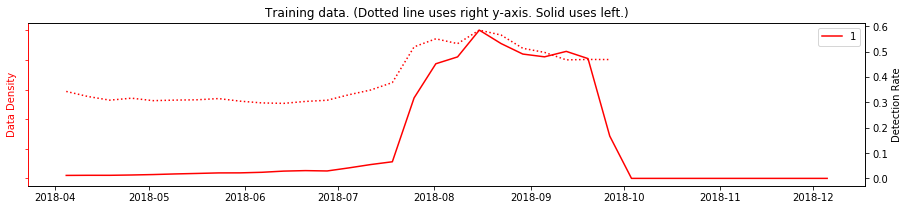

In [0]:
df_train['ones'] = 1
dynamicPlot(df_train,'ones',title='Training data. (Dotted line uses right y-axis. Solid uses left.)')

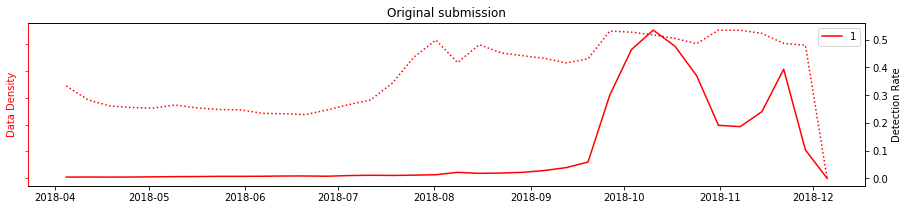

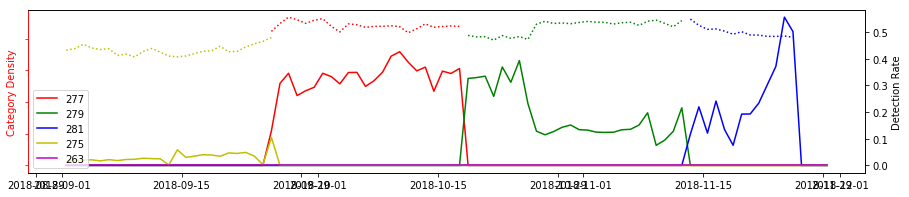

In [0]:
df_test2['ones'] = 1
dynamicPlot(df_test2,'ones',title='Original submission')
dynamicPlot(df_test2,'AvSigVersion2',start=datetime(2018,9,1),end=datetime(2018,11,29),inc_dy=1,top2=4)

In [0]:
if AdjustPublicScore: df_test2.loc[ (df_test2['AvSigVersion2']==275)|(df_test2['AvSigVersion2']==273),'HasDetections'] *= 0.6

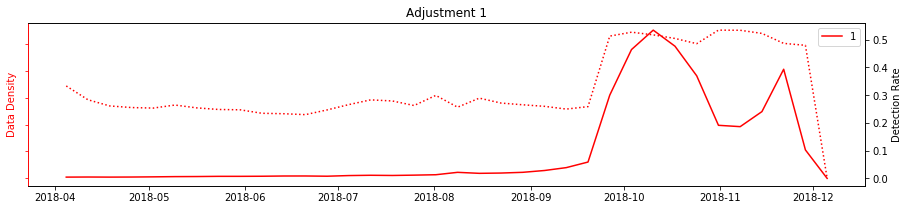

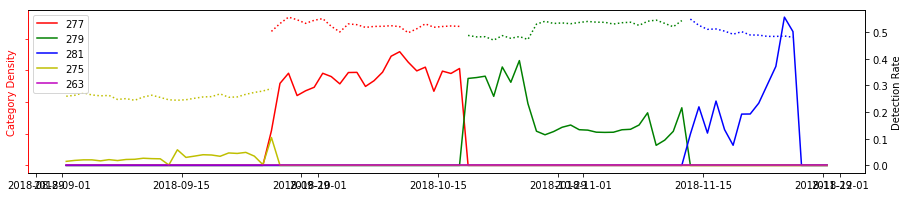

In [0]:
dynamicPlot(df_test2,'ones',title='Adjustment 1')
dynamicPlot(df_test2,'AvSigVersion2',start=datetime(2018,9,1),end=datetime(2018,11,29),inc_dy=1,top2=4)

In [0]:
if AdjustPrivateScore==1:
    df_test2.loc[ df_test2['Date']>datetime(2018,11,20,4,0) ,'HasDetections'] = 0
elif AdjustPrivateScore==2:
    df_test2['X'] = df_test2['Date'] - datetime(2018,11,20,4,0) 
    df_test2['X'] = df_test2['X'].map(lambda x: x.total_seconds()/86400)
    df_test2['X'].fillna(0,inplace=True)
    s = 5.813888
    df_test2['F'] = 1.0
    df_test2['F'] = 1 - df_test2['X']/s
    df_test2.loc[df_test2['X']<=0,'F'] = 1.0
    df_test2.loc[df_test2['X']>s,'F'] = 0
    df_test2['HasDetections'] *= df_test2['F']

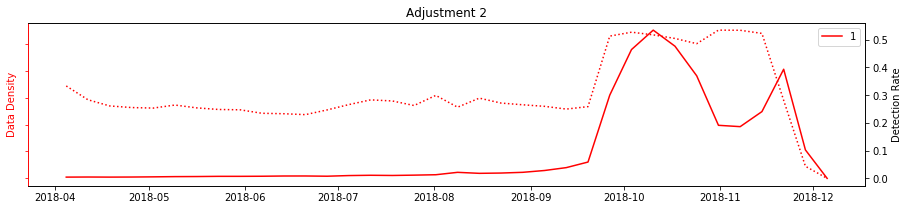

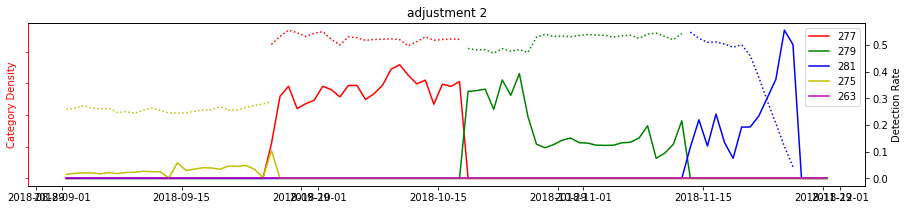

In [0]:
dynamicPlot(df_test2,'ones',title='Adjustment 2')
dynamicPlot(df_test2,'AvSigVersion2',start=datetime(2018,9,1),end=datetime(2018,11,29),inc_dy=1,top2=4,
            title='adjustment 2')

In [0]:
df_test2[['MachineIdentifier','HasDetections']].to_csv('PrivateLeaderboard2.csv', index=False)

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'PrivateLeaderboard.csv'})
uploaded.SetContentFile('PrivateLeaderboard.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

    100% |████████████████████████████████| 993kB 18.8MB/s 


update: private score and public score respectively is 0.74964
0.69256

## Ok, now to try Kfold cross validation with count encoding: 
inspired by: https://www.kaggle.com/sanderf/7th-place-solution-microsoft-malware-prediction and https://www.kaggle.com/c/microsoft-malware-prediction/discussion/86888#latest-504802

In [0]:
import numpy as np
import pandas as pd
import gc
import time
import random
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plot
import seaborn as sb

In [0]:
#vars
dataFolder = '/content/'
submissionFileName = 'submission'
trainFile='train.csv.zip'
testFile='test.csv.zip'
#used 4000000 nr of rows in stead of 8000000 because of Kernel memory issue
numberOfRows = 2000000

In [0]:
seed = 6001
np.random.seed(seed)
random.seed(seed)

In [0]:
def displayImportances(featureImportanceDf, submissionFileName):
    cols = featureImportanceDf[["feature", "importance"]].groupby("feature").mean().sort_values(by = "importance", ascending = False).index
    bestFeatures = featureImportanceDf.loc[featureImportanceDf.feature.isin(cols)]
    plot.figure(figsize = (14, 14))
    sb.barplot(x = "importance", y = "feature", data = bestFeatures.sort_values(by = "importance", ascending = False))
    plot.title('LightGBM Features')
    plot.tight_layout()
    plot.savefig(submissionFileName + '.png')

In [0]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

selectedFeatures = [  
    'AVProductStatesIdentifier'
    ,'AVProductsEnabled'
    ,'IsProtected'
    ,'Processor'
    ,'OsSuite'
    ,'IsProtected'
    ,'RtpStateBitfield'
    ,'AVProductsInstalled'
    ,'Wdft_IsGamer'
    ,'DefaultBrowsersIdentifier'
    ,'OsBuild'
    ,'Wdft_RegionIdentifier'
    ,'SmartScreen'
    ,'CityIdentifier'
    ,'AppVersion'
    ,'Census_IsSecureBootEnabled'
    ,'Census_PrimaryDiskTypeName'
    ,'Census_SystemVolumeTotalCapacity'
    ,'Census_HasOpticalDiskDrive'
    ,'Census_IsWIMBootEnabled'
    ,'Census_IsVirtualDevice'
    ,'Census_IsTouchEnabled'
    ,'Census_FirmwareVersionIdentifier'
    ,'GeoNameIdentifier'
    ,'IeVerIdentifier'
    ,'Census_FirmwareManufacturerIdentifier'
    ,'Census_InternalPrimaryDisplayResolutionHorizontal'
    ,'Census_InternalPrimaryDisplayResolutionVertical'
    ,'Census_OEMModelIdentifier'
    ,'Census_ProcessorModelIdentifier'
    ,'Census_OSVersion'
    ,'Census_InternalPrimaryDiagonalDisplaySizeInInches'
    ,'Census_OEMNameIdentifier'
    ,'Census_ChassisTypeName'
    ,'Census_OSInstallLanguageIdentifier'
    ,'EngineVersion'
    ,'OrganizationIdentifier' 
    ,'CountryIdentifier'   
    ,'Census_ActivationChannel'
    ,'Census_ProcessorCoreCount'
    ,'Census_OSWUAutoUpdateOptionsName'
    ,'Census_InternalBatteryType'
    ]

In [0]:
# Load Data with selected features
trainDf = pd.read_csv(dataFolder + trainFile, dtype=dtypes, usecols=selectedFeatures, low_memory=True, nrows = numberOfRows)
labels = pd.read_csv(dataFolder + trainFile, usecols = ['HasDetections'], nrows = numberOfRows)
testDf = pd.read_csv(dataFolder + testFile, dtype=dtypes, usecols=selectedFeatures, low_memory=True, nrows = numberOfRows)
print('== Dataset Shapes ==')
print('Train : ' + str(trainDf.shape))
print('Labels : ' + str(labels.shape))
print('Test : ' + str(testDf.shape))

== Dataset Shapes ==
Train : (2000000, 41)
Labels : (2000000, 1)
Test : (2000000, 41)


In [0]:
# Append Datasets and Cleanup
df = trainDf.append(testDf).reset_index()
del trainDf, testDf
gc.collect()

17297

In [0]:
# Modify SmartScreen Feature
df.loc[df.SmartScreen == 'off', 'SmartScreen'] = 'Off'
df.loc[df.SmartScreen == 'of', 'SmartScreen'] = 'Off'
df.loc[df.SmartScreen == 'OFF', 'SmartScreen'] = 'Off'
df.loc[df.SmartScreen == '00000000', 'SmartScreen'] = 'Off'
df.loc[df.SmartScreen == '0', 'SmartScreen'] = 'Off'       
df.loc[df.SmartScreen == 'ON', 'SmartScreen'] = 'On'
df.loc[df.SmartScreen == 'on', 'SmartScreen'] = 'On'
df.loc[df.SmartScreen == 'Enabled', 'SmartScreen'] = 'On'
df.loc[df.SmartScreen == 'BLOCK', 'SmartScreen'] = 'Block'
df.loc[df.SmartScreen == 'requireadmin', 'SmartScreen'] = 'RequireAdmin'
df.loc[df.SmartScreen == 'requireAdmin', 'SmartScreen'] = 'RequireAdmin'
df.loc[df.SmartScreen == 'RequiredAdmin', 'SmartScreen'] = 'RequireAdmin'
df.loc[df.SmartScreen == 'Promt', 'SmartScreen'] = 'Prompt'
df.loc[df.SmartScreen == 'Promprt', 'SmartScreen'] = 'Prompt'
df.loc[df.SmartScreen == 'prompt', 'SmartScreen'] = 'Prompt'
df.loc[df.SmartScreen == 'warn', 'SmartScreen'] = 'Warn'
df.loc[df.SmartScreen == 'Deny', 'SmartScreen'] = 'Block'
df.loc[df.SmartScreen == '&#x03;', 'SmartScreen'] = 'Off'

In [0]:
#Count Encoding (with exceptions)
for col in [f for f in df.columns if f not in ['index','HasDetections','Census_SystemVolumeTotalCapacity']]:
    df[col]=df[col].map(df[col].value_counts())

dfDummy = pd.get_dummies(df, dummy_na=True)
print('Dummy: ' + str(dfDummy.shape))

# Cleanup
del df
gc.collect()

Dummy: (4000000, 42)


360

In [0]:
# Split back to train and test
train = dfDummy[:numberOfRows]
test = dfDummy[numberOfRows:]

# Cleanup
del dfDummy
gc.collect()

# Summary Shape
print('== Dataset Shapes ==')
print('Train: ' + str(train.shape))
print('Test: ' + str(test.shape))

# Summary Columns
print('== Dataset Columns ==')
features = [f for f in train.columns if f not in ['index']]
for feature in features:
    print(feature)


== Dataset Shapes ==
Train: (2000000, 42)
Test: (2000000, 42)
== Dataset Columns ==
EngineVersion
AppVersion
RtpStateBitfield
DefaultBrowsersIdentifier
AVProductStatesIdentifier
AVProductsInstalled
AVProductsEnabled
CountryIdentifier
CityIdentifier
OrganizationIdentifier
GeoNameIdentifier
Processor
OsBuild
OsSuite
IsProtected
IeVerIdentifier
SmartScreen
Census_OEMNameIdentifier
Census_OEMModelIdentifier
Census_ProcessorCoreCount
Census_ProcessorModelIdentifier
Census_PrimaryDiskTypeName
Census_SystemVolumeTotalCapacity
Census_HasOpticalDiskDrive
Census_ChassisTypeName
Census_InternalPrimaryDiagonalDisplaySizeInInches
Census_InternalPrimaryDisplayResolutionHorizontal
Census_InternalPrimaryDisplayResolutionVertical
Census_InternalBatteryType
Census_OSVersion
Census_OSInstallLanguageIdentifier
Census_OSWUAutoUpdateOptionsName
Census_ActivationChannel
Census_FirmwareManufacturerIdentifier
Census_FirmwareVersionIdentifier
Census_IsSecureBootEnabled
Census_IsWIMBootEnabled
Census_IsVirtualDe

In [0]:
# CV Folds
folds = StratifiedKFold(n_splits = 2, shuffle = True, random_state = seed)

# Create arrays and dataframes to store results
oofPreds = np.zeros(train.shape[0])
subPreds = np.zeros(test.shape[0])
featureImportanceDf = pd.DataFrame()

# Loop through all Folds.
for n_fold, (trainXId, validXId) in enumerate(folds.split(train[features], labels)):
    # Create TrainXY and ValidationXY set based on fold-indexes
    trainX, trainY = train[features].iloc[trainXId], labels.iloc[trainXId]
    validX, validY = train[features].iloc[validXId], labels.iloc[validXId]

    print('== Fold: ' + str(n_fold))

    # LightGBM parameters
    lgbm = LGBMClassifier(
        objective = 'binary',
        boosting_type = 'gbdt',
        n_estimators = 2500,
        learning_rate = 0.1, 
        num_leaves = 75,
        min_data_in_leaf = 125, 
        bagging_fraction = 0.901,
        max_depth = 13, 
        reg_alpha = 2.5,
        reg_lambda = 2.5,
        min_split_gain = 0.0001,
        min_child_weight = 25,
        feature_fraction = 0.5, 
        silent = -1,
        verbose = -1,
        #n_jobs is set to -1 instead of 4 otherwise the kernell will time out
        n_jobs = 4) 

    lgbm.fit(trainX, trainY, 
        eval_set=[(trainX, trainY), (validX, validY)], 
        eval_metric = 'auc', 
        verbose = 100, 
        early_stopping_rounds = 10)

    oofPreds[validXId] = lgbm.predict_proba(validX, num_iteration = lgbm.best_iteration_)[:, 1]
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(validY, oofPreds[validXId])))
    
    # cleanup
    print('Cleanup')
    del trainX, trainY, validX, validY
    gc.collect()

    subPreds += lgbm.predict_proba(test[features], num_iteration = lgbm.best_iteration_)[:, 1] / folds.n_splits
        
    # Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgbm.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    featureImportanceDf = pd.concat([featureImportanceDf, fold_importance_df], axis=0)
        
    # cleanup
    print('Cleanup. Post-Fold')
    del lgbm
    gc.collect()

== Fold: 0


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 10 rounds.
[100]	training's auc: 0.7209	training's binary_logloss: 0.6113	valid_1's auc: 0.714981	valid_1's binary_logloss: 0.615175
[200]	training's auc: 0.730741	training's binary_logloss: 0.604192	valid_1's auc: 0.719026	valid_1's binary_logloss: 0.612095
[300]	training's auc: 0.737907	training's binary_logloss: 0.599036	valid_1's auc: 0.720592	valid_1's binary_logloss: 0.610873
[400]	training's auc: 0.743964	training's binary_logloss: 0.594694	valid_1's auc: 0.721349	valid_1's binary_logloss: 0.61027
[500]	training's auc: 0.749693	training's binary_logloss: 0.590618	valid_1's auc: 0.721878	valid_1's binary_logloss: 0.609838
Early stopping, best iteration is:
[492]	training's auc: 0.74928	training's binary_logloss: 0.590913	valid_1's auc: 0.721881	valid_1's binary_logloss: 0.609841
Fold  1 AUC : 0.721881
Cleanup
Cleanup. Post-Fold
== Fold: 1


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[100]	training's auc: 0.72054	training's binary_logloss: 0.611756	valid_1's auc: 0.715424	valid_1's binary_logloss: 0.614867
[200]	training's auc: 0.730247	training's binary_logloss: 0.604681	valid_1's auc: 0.719507	valid_1's binary_logloss: 0.61172
[300]	training's auc: 0.737257	training's binary_logloss: 0.599674	valid_1's auc: 0.721014	valid_1's binary_logloss: 0.610534
[400]	training's auc: 0.7432	training's binary_logloss: 0.59544	valid_1's auc: 0.721804	valid_1's binary_logloss: 0.609909
[500]	training's auc: 0.74889	training's binary_logloss: 0.591257	valid_1's auc: 0.722514	valid_1's binary_logloss: 0.609327
[600]	training's auc: 0.754197	training's binary_logloss: 0.587291	valid_1's auc: 0.723113	valid_1's binary_logloss: 0.60883
Early stopping, best iteration is:
[613]	training's auc: 0.754871	training's binary_logloss: 0.586789	valid_1's auc: 0.723181	valid_1's binary_logloss: 0.608774
Fold  2 AUC : 0.723181
Cleanup


Full AUC score 0.722530


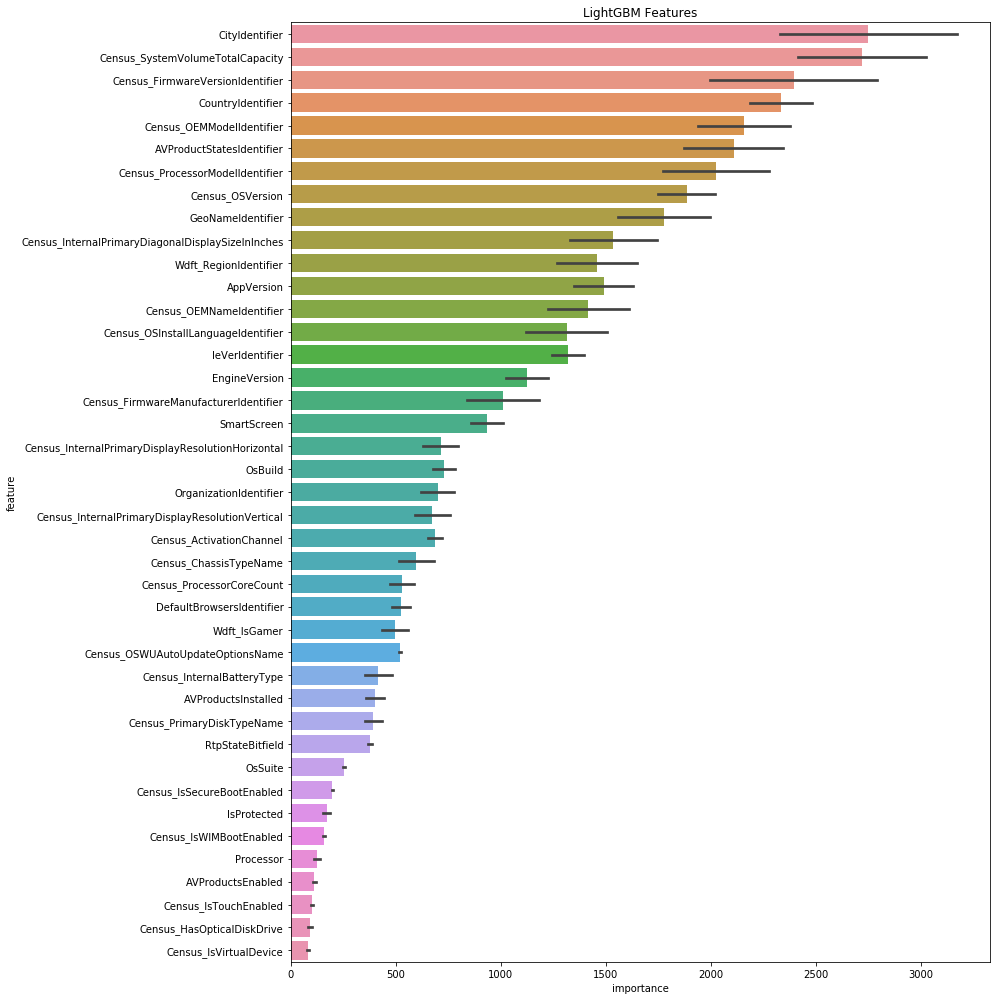

In [0]:
print('Full AUC score %.6f' % roc_auc_score(labels, oofPreds))

# Feature Importance
displayImportances(featureImportanceDf, submissionFileName)


In [0]:
kaggleSubmission = pd.read_csv(dataFolder + 'sample_submission.csv.zip')
kaggleSubmission['HasDetections'] = subPreds
kaggleSubmission.to_csv(submissionFileName + '.csv', index = False)

Kaggle pulblic score .6042, private score of .6204

shows how difficult this problem was to capture irl - this was the 7th place score

# More Feature Analysis with specialized LGBM

In [0]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [0]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import KFold
import warnings
import gc
import time
import sys
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn import metrics
# Plotly library
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
from plotly import tools
init_notebook_mode(connected=True)
pd.set_option('display.max_columns', 500)

In [0]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

In [0]:
numerics = ['int8', 'int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerical_columns = [c for c,v in dtypes.items() if v in numerics]
categorical_columns = [c for c,v in dtypes.items() if v not in numerics]

In [0]:
nrows = 1000000
#_______________________________________________________________________________
retained_columns = numerical_columns + categorical_columns
train = pd.read_csv('/content/train.csv.zip',
                    nrows = nrows,
                    usecols = retained_columns,
                    dtype = dtypes)
#_______________________________________________________________
retained_columns += ['MachineIdentifier']
retained_columns.remove('HasDetections')
test = pd.read_csv('/content/test.csv.zip',
                   usecols = retained_columns,
                   dtype = dtypes)

In [0]:
true_numerical_columns = [
    'Census_ProcessorCoreCount',
    'Census_PrimaryDiskTotalCapacity',
    'Census_SystemVolumeTotalCapacity',
    'Census_TotalPhysicalRAM',
    'Census_InternalPrimaryDiagonalDisplaySizeInInches',
    'Census_InternalPrimaryDisplayResolutionHorizontal',
    'Census_InternalPrimaryDisplayResolutionVertical',
    'Census_InternalBatteryNumberOfCharges'
]

In [0]:
binary_variables = [c for c in train.columns if train[c].nunique() == 2]

In [0]:
categorical_columns = [c for c in train.columns 
                       if (c not in true_numerical_columns) & (c not in binary_variables)]

In [0]:
variables = {
    'categorical_columns': len(categorical_columns),
    'binary_variables': len(binary_variables),
    'true_numerical_columns': len(true_numerical_columns)
}
pie_trace = go.Pie(labels=list(variables.keys()), values=list(variables.values()))
layout = dict(title= "Variable types", height=400, width=800)
fig = dict(data=[pie_trace], layout=layout)
iplot(fig)

In [0]:
cardinality = []
for c in categorical_columns:
    if c == 'MachineIdentifier': continue
    cardinality.append([c, train[c].nunique()])
cardinality.sort(key = lambda x:x[1], reverse=False)

trace = go.Bar(y=[x[0] for x in cardinality],
               x=[x[1] for x in cardinality],
               orientation='h', marker=dict(color='rgb(49,130,189)'), name='train')

layout = go.Layout(
    title='Categorical cardinality', height=1600, width=800,
    xaxis=dict(
        title='Number of categories',
        titlefont=dict(size=16, color='rgb(107, 107, 107)'),
        domain=[0.25, 1]
    ),
    barmode='group',
    bargap=0.1,
    bargroupgap=0.1
)

fig = go.Figure(data=[trace], layout=layout)
iplot(fig)

In [0]:
def frequency_encoding(variable):
    t = pd.concat([train[variable], test[variable]]).value_counts().reset_index()
    t = t.reset_index()
    t.loc[t[variable] == 1, 'level_0'] = np.nan
    t.set_index('index', inplace=True)
    max_label = t['level_0'].max() + 1
    t.fillna(max_label, inplace=True)
    return t.to_dict()['level_0']

In [0]:
frequency_encoded_variables = [
    'Census_OEMModelIdentifier',
    'CityIdentifier',
    'Census_FirmwareVersionIdentifier',
    'AvSigVersion',
    'Census_ProcessorModelIdentifier',
    'Census_OEMNameIdentifier',
    'DefaultBrowsersIdentifier'
]

In [0]:
for variable in tqdm(frequency_encoded_variables):
    freq_enc_dict = frequency_encoding(variable)
    train[variable] = train[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    test[variable] = test[variable].map(lambda x: freq_enc_dict.get(x, np.nan))
    categorical_columns.remove(variable)

100%|██████████| 7/7 [00:28<00:00,  3.98s/it]


In [0]:
indexer = {}
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    _, indexer[col] = pd.factorize(train[col])
    
for col in tqdm(categorical_columns):
    if col == 'MachineIdentifier': continue
    train[col] = indexer[col].get_indexer(train[col])
    test[col] = indexer[col].get_indexer(test[col])

100%|██████████| 49/49 [08:25<00:00,  5.53s/it]


In [0]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Mem. usage decreased to 172.56 Mb (66.9% reduction)
Mem. usage decreased to 1353.54 Mb (66.9% reduction)


In [0]:
train[:5]

,MachineIdentifier,ProductName,EngineVersion,AppVersion,AvSigVersion,IsBeta,RtpStateBitfield,IsSxsPassiveMode,DefaultBrowsersIdentifier,AVProductStatesIdentifier,AVProductsInstalled,AVProductsEnabled,HasTpm,CountryIdentifier,CityIdentifier,OrganizationIdentifier,GeoNameIdentifier,LocaleEnglishNameIdentifier,Platform,Processor,OsVer,OsBuild,OsSuite,OsPlatformSubRelease,OsBuildLab,SkuEdition,IsProtected,AutoSampleOptIn,PuaMode,SMode,IeVerIdentifier,SmartScreen,Firewall,UacLuaenable,Census_MDC2FormFactor,Census_DeviceFamily,Census_OEMNameIdentifier,Census_OEMModelIdentifier,Census_ProcessorCoreCount,Census_ProcessorManufacturerIdentifier,Census_ProcessorModelIdentifier,Census_ProcessorClass,Census_PrimaryDiskTotalCapacity,Census_PrimaryDiskTypeName,Census_SystemVolumeTotalCapacity,Census_HasOpticalDiskDrive,Census_TotalPhysicalRAM,Census_ChassisTypeName,Census_InternalPrimaryDiagonalDisplaySizeInInches,Census_InternalPrimaryDisplayResolutionHorizontal,Census_InternalPrimaryDisplayResolutionVertical,Census_PowerPlatformRoleName,Census_InternalBatteryType,Census_InternalBatteryNumberOfCharges,Census_OSVersion,Census_OSArchitecture,Census_OSBranch,Census_OSBuildNumber,Census_OSBuildRevision,Census_OSEdition,Census_OSSkuName,Census_OSInstallTypeName,Census_OSInstallLanguageIdentifier,Census_OSUILocaleIdentifier,Census_OSWUAutoUpdateOptionsName,Census_IsPortableOperatingSystem,Census_GenuineStateName,Census_ActivationChannel,Census_IsFlightingInternal,Census_IsFlightsDisabled,Census_FlightRing,Census_ThresholdOptIn,Census_FirmwareManufacturerIdentifier,Census_FirmwareVersionIdentifier,Census_IsSecureBootEnabled,Census_IsWIMBootEnabled,Census_IsVirtualDevice,Census_IsTouchEnabled,Census_IsPenCapable,Census_IsAlwaysOnAlwaysConnectedCapable,Wdft_IsGamer,Wdft_RegionIdentifier,HasDetections
0,0000028988387b115f69f31a3bf04f09,0,0,0,786.0,0,0,0,NaN,0,0,0,1,0,215.0,0,0,0,0,0,0,0,0,0,0,0,1.0,0,-1,0.0,0,-1,1.0,0,0,0,0.0,22932.0,4.0,0,134.0,-1,476940.0,0,299451.0,0,4096.0,0,18.906250,1440.0,900.0,0,-1,4.294967e+09,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,0.0,0,NaN,0,2680.0,0,-1,0.0,0,0,0.0,0.0,0,0
1,000007535c3f730efa9ea0b7ef1bd645,0,1,1,0.0,0,0,0,NaN,0,0,0,1,1,172.0,0,1,1,0,0,0,0,0,0,0,0,1.0,0,-1,0.0,0,-1,1.0,0,1,0,0.0,77659.0,4.0,0,90.0,-1,476940.0,0,102385.0,0,4096.0,1,13.898438,1366.0,768.0,1,-1,1.000000e+00,1,0,0,0,1,0,0,1,1,1,0,0,1,0,NaN,0.0,1,NaN,0,1192.0,0,-1,0.0,0,0,0.0,0.0,1,0
2,000007905a28d863f6d0d597892cd692,0,0,0,1139.0,0,0,0,NaN,0,0,0,1,2,665.0,0,2,2,0,0,0,0,1,0,0,1,1.0,0,-1,0.0,0,0,1.0,0,0,0,10.0,2.0,4.0,0,187.0,-1,114473.0,1,113907.0,0,4096.0,0,21.500000,1920.0,1080.0,0,-1,4.294967e+09,0,0,0,0,0,1,1,0,2,2,1,0,0,1,NaN,0.0,0,NaN,1,176.0,0,-1,0.0,0,0,0.0,0.0,2,0
3,00000b11598a75ea8ba1beea8459149f,0,0,0,416.0,0,0,0,NaN,0,0,0,1,3,20.0,-1,3,3,0,0,0,0,0,0,0,0,1.0,0,-1,0.0,0,1,1.0,0,0,0,2.0,140.0,4.0,0,58.0,-1,238475.0,2,227116.0,0,4096.0,2,18.500000,1366.0,768.0,0,-1,4.294967e+09,2,0,0,0,2,0,0,0,3,3,1,0,0,1,NaN,0.0,0,NaN,2,30.0,0,-1,0.0,0,0,0.0,0.0,2,1
4,000014a5f00daa18e76b81417eeb99fc,0,0,0,269.0,0,0,0,NaN,0,0,0,1,4,12.0,-1,4,4,0,0,0,0,1,0,0,1,1.0,0,-1,0.0,0,0,1.0,0,1,0,2.0,2294.0,4.0,0,54.0,-1,476940.0,0,101900.0,0,6144.0,3,14.000000,1366.0,768.0,1,0,0.000000e+00,3,0,0,0,3,1,1,2,1,1,1,0,0,0,0.0,0.0,0,0.0,2,132.0,0,0,0.0,0,0,0.0,0.0,3,1


In [0]:
target = train['HasDetections']
del train['HasDetections']

In [0]:
param = {'num_leaves': 60,
         'min_data_in_leaf': 60, 
         'objective':'binary',
         'max_depth': -1,
         'learning_rate': 0.1,
         "boosting": "gbdt",
         "feature_fraction": 0.8,
         "bagging_freq": 1,
         "bagging_fraction": 0.8 ,
         "bagging_seed": 11,
         "metric": 'auc',
         "lambda_l1": 0.1,
         "random_state": 133,
         "verbosity": -1}

In [0]:
max_iter = 5

In [0]:
gc.collect()

15799

In [0]:
folds = KFold(n_splits=3, shuffle=True, random_state=15)
oof = np.zeros(len(train))
categorical_columns = [c for c in categorical_columns if c not in ['MachineIdentifier']]
features = [c for c in train.columns if c not in ['MachineIdentifier']]
predictions = np.zeros(len(test))
start = time.time()
feature_importance_df = pd.DataFrame()
start_time= time.time()
score = [0 for _ in range(folds.n_splits)]

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features],
                           label=target.iloc[trn_idx],
                           categorical_feature = categorical_columns
                          )
    val_data = lgb.Dataset(train.iloc[val_idx][features],
                           label=target.iloc[val_idx],
                           categorical_feature = categorical_columns
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=100,
                    early_stopping_rounds = 40)
    
    oof[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance(importance_type='gain')
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    # we perform predictions by chunks
    initial_idx = 0
    chunk_size = 1000000
    current_pred = np.zeros(len(test))
    while initial_idx < test.shape[0]:
        final_idx = min(initial_idx + chunk_size, test.shape[0])
        idx = range(initial_idx, final_idx)
        current_pred[idx] = clf.predict(test.iloc[idx][features], num_iteration=clf.best_iteration)
        initial_idx = final_idx
    predictions += current_pred / min(folds.n_splits, max_iter)
   
    print("time elapsed: {:<5.2}s".format((time.time() - start_time) / 3600))
    score[fold_] = metrics.roc_auc_score(target.iloc[val_idx], oof[val_idx])
    if fold_ == max_iter - 1: break
        
if (folds.n_splits == max_iter):
    print("CV score: {:<8.5f}".format(metrics.roc_auc_score(target, oof)))
else:
     print("CV score: {:<8.5f}".format(sum(score) / max_iter))

fold n°0


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 40 rounds.
[100]	training's auc: 0.752461	valid_1's auc: 0.720688
[200]	training's auc: 0.771883	valid_1's auc: 0.722021
Early stopping, best iteration is:
[204]	training's auc: 0.772455	valid_1's auc: 0.722038
time elapsed: 0.077s
fold n°1


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 40 rounds.
[100]	training's auc: 0.752837	valid_1's auc: 0.720519
Early stopping, best iteration is:
[145]	training's auc: 0.762264	valid_1's auc: 0.721179
time elapsed: 0.13 s
fold n°2


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1205: UserWarning:

Using categorical_feature in Dataset.

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:762: UserWarning:

categorical_feature in param dict is overridden.



Training until validation scores don't improve for 40 rounds.
[100]	training's auc: 0.752495	valid_1's auc: 0.721293
[200]	training's auc: 0.770956	valid_1's auc: 0.722193
Early stopping, best iteration is:
[203]	training's auc: 0.771414	valid_1's auc: 0.72223
time elapsed: 0.21 s
CV score: 0.43309 


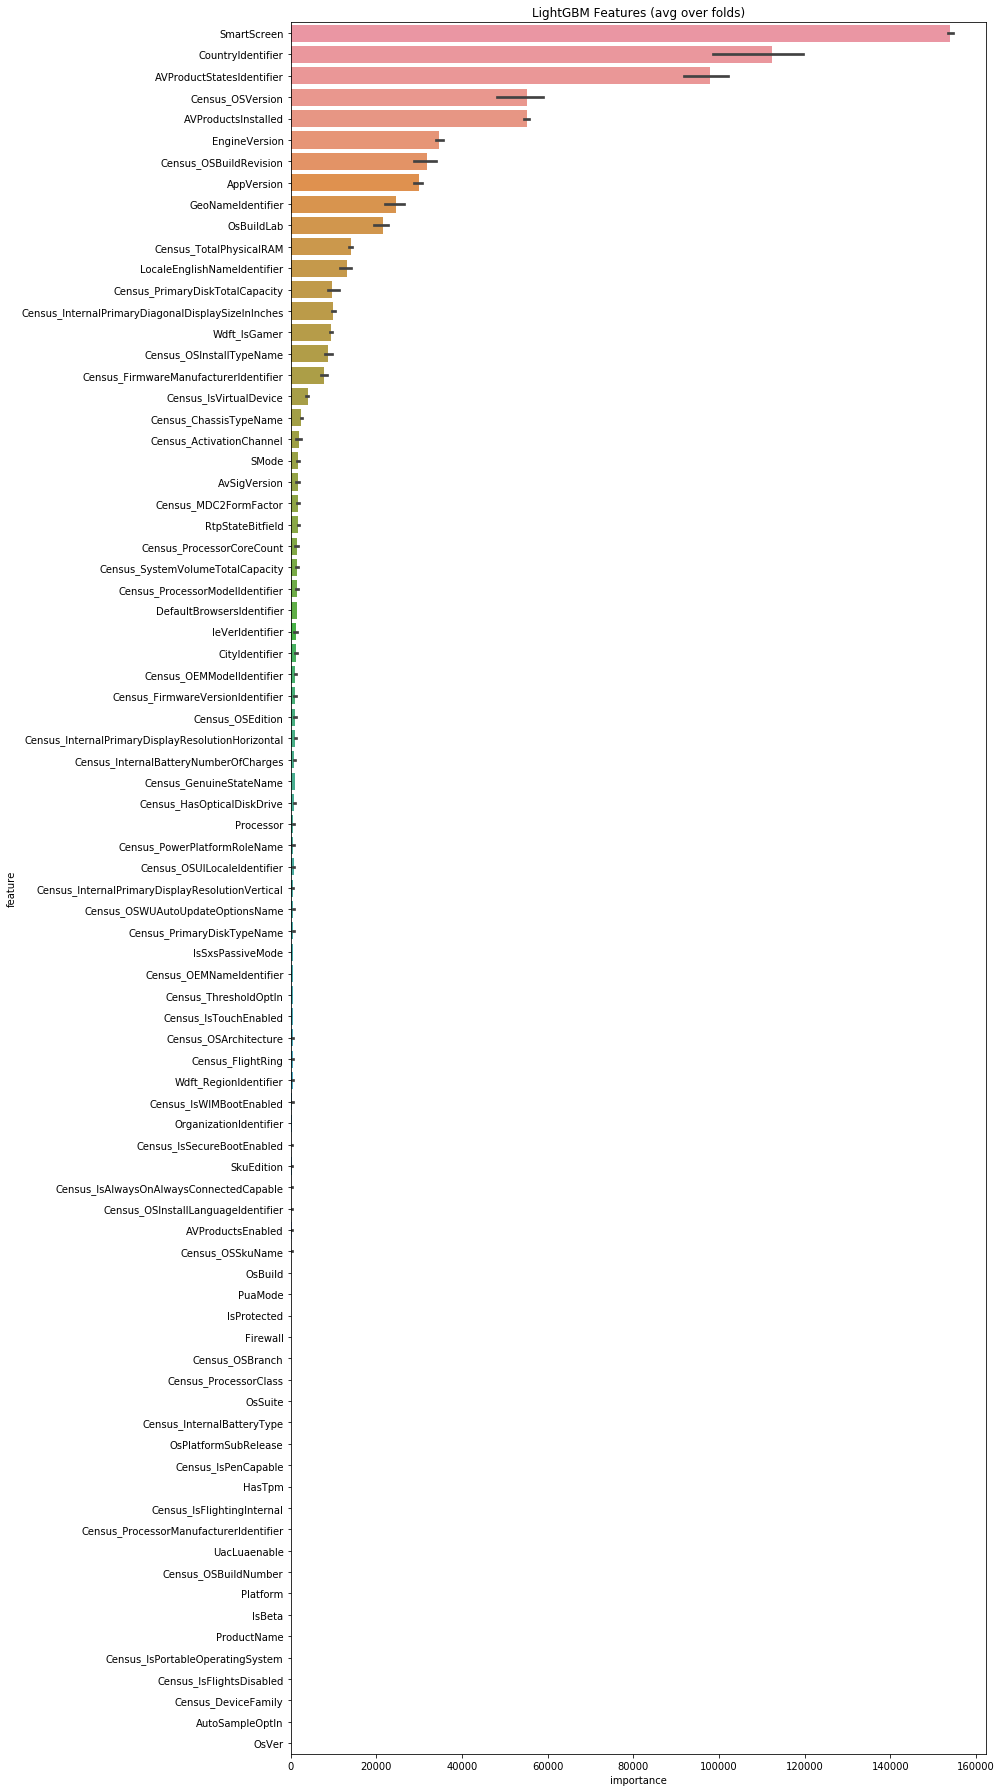

In [0]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(14,25))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')

In [0]:
sub_df = pd.DataFrame({"MachineIdentifier": test["MachineIdentifier"].values})
sub_df["HasDetections"] = predictions
sub_df[:10]

,MachineIdentifier,HasDetections
0,0000010489e3af074adeac69c53e555e,0.529715
1,00000176ac758d54827acd545b6315a5,0.492156
2,0000019dcefc128c2d4387c1273dae1d,0.428545
3,0000055553dc51b1295785415f1a224d,0.311888
4,00000574cefffeca83ec8adf9285b2bf,0.418045
5,000007ffedd31948f08e6c16da31f6d1,0.507356
6,000008f31610018d898e5f315cdf1bd1,0.283988
7,00000a3c447250626dbcc628c9cbc460,0.352340
8,00000b6bf217ec9aef0f68d5c6705897,0.521972
9,00000b8d3776b13e93ad83676a28e4aa,0.269586


In [0]:
sub_df.to_csv("submit.csv", index=False)

In [0]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'submit.csv'})
uploaded.SetContentFile('submit.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

    100% |████████████████████████████████| 993kB 22.0MB/s 
  Stored in directory: /root/.cache/pip/wheels/fa/d2/9a/d3b6b506c2da98289e5d417215ce34b696db856643bad779f4
Successfully built pydrive
Uploaded file with ID 1LQSYwj8KpL2-T8d0UKH0yB2W84Dug467


# Ok so based on the results above, I am going to try k fold with only 4 features

In [0]:
import numpy as np
import pandas as pd
import gc
import time
import random
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plot
import seaborn as sb

In [0]:
#vars
dataFolder = '/content/'
submissionFileName = 'submission'
trainFile='train.csv.zip'
testFile='test.csv.zip'
#used 4000000 nr of rows in stead of 8000000 because of Kernel memory issue
numberOfRows = 2500000

In [0]:
seed = 6001
np.random.seed(seed)
random.seed(seed)

In [0]:
def displayImportances(featureImportanceDf, submissionFileName):
    cols = featureImportanceDf[["feature", "importance"]].groupby("feature").mean().sort_values(by = "importance", ascending = False).index
    bestFeatures = featureImportanceDf.loc[featureImportanceDf.feature.isin(cols)]
    plot.figure(figsize = (14, 14))
    sb.barplot(x = "importance", y = "feature", data = bestFeatures.sort_values(by = "importance", ascending = False))
    plot.title('LightGBM Features')
    plot.tight_layout()
    plot.savefig(submissionFileName + '.png')

In [0]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

selectedFeatures = [  
    'CountryIdentifier',                                  
    'CityIdentifier',                                      
    #'SmartScreen',                                         
    'Census_SystemVolumeTotalCapacity', 
    'AVProductStatesIdentifier'
    ]

In [0]:
trainDf = pd.read_csv(dataFolder + trainFile, dtype=dtypes, usecols=selectedFeatures, low_memory=True, nrows = numberOfRows)
labels = pd.read_csv(dataFolder + trainFile, usecols = ['HasDetections'], nrows = numberOfRows)
testDf = pd.read_csv(dataFolder + testFile, dtype=dtypes, usecols=selectedFeatures, low_memory=True)
print('== Dataset Shapes ==')
print('Train : ' + str(trainDf.shape))
print('Labels : ' + str(labels.shape))
print('Test : ' + str(testDf.shape))

== Dataset Shapes ==
Train : (2500000, 4)
Labels : (2500000, 1)
Test : (7853253, 4)


In [0]:
# Append Datasets and Cleanup
df = trainDf.append(testDf).reset_index()
del trainDf, testDf
gc.collect()

2332

In [0]:
#Count Encoding (with exceptions)
for col in [f for f in df.columns if f not in ['index','HasDetections','Census_SystemVolumeTotalCapacity']]:
    df[col]=df[col].map(df[col].value_counts())

dfDummy = pd.get_dummies(df, dummy_na=True)
print('Dummy: ' + str(dfDummy.shape))

# Cleanup
del df
gc.collect()

Dummy: (10353253, 5)


57

In [0]:
# Split back to train and test
train = dfDummy[:numberOfRows]
test = dfDummy[numberOfRows:]

# Cleanup
del dfDummy
gc.collect()

# Summary Shape
print('== Dataset Shapes ==')
print('Train: ' + str(train.shape))
print('Test: ' + str(test.shape))

# Summary Columns
print('== Dataset Columns ==')
features = [f for f in train.columns if f not in ['index']]
for feature in features:
    print(feature)

== Dataset Shapes ==
Train: (2500000, 5)
Test: (7853253, 5)
== Dataset Columns ==
AVProductStatesIdentifier
CountryIdentifier
CityIdentifier
Census_SystemVolumeTotalCapacity


In [0]:
# CV Folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)

# Create arrays and dataframes to store results
oofPreds = np.zeros(train.shape[0])
subPreds = np.zeros(test.shape[0])
featureImportanceDf = pd.DataFrame()

# Loop through all Folds.
for n_fold, (trainXId, validXId) in enumerate(folds.split(train[features], labels)):
    # Create TrainXY and ValidationXY set based on fold-indexes
    trainX, trainY = train[features].iloc[trainXId], labels.iloc[trainXId]
    validX, validY = train[features].iloc[validXId], labels.iloc[validXId]

    print('== Fold: ' + str(n_fold))

    # LightGBM parameters
    lgbm = LGBMClassifier(
        objective = 'binary',
        boosting_type = 'gbdt',
        n_estimators = 2500,
        learning_rate = 0.1, 
        num_leaves = 200,
        min_data_in_leaf = 125, 
        bagging_fraction = 0.901,
        max_depth = 13, 
        reg_alpha = 2.5,
        reg_lambda = 2.5,
        min_split_gain = 0.0001,
        min_child_weight = 25,
        feature_fraction = 0.5, 
        silent = -1,
        verbose = -1,
        #n_jobs is set to -1 instead of 4 otherwise the kernell will time out
        n_jobs = 4) 

    lgbm.fit(trainX, trainY, 
        eval_set=[(trainX, trainY), (validX, validY)], 
        eval_metric = 'auc', 
        verbose = 100, 
        early_stopping_rounds = 125)

    oofPreds[validXId] = lgbm.predict_proba(validX, num_iteration = lgbm.best_iteration_)[:, 1]
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(validY, oofPreds[validXId])))
    
    # cleanup
    print('Cleanup')
    del trainX, trainY, validX, validY
    gc.collect()

    subPreds += lgbm.predict_proba(test[features], num_iteration = lgbm.best_iteration_)[:, 1] / folds.n_splits
        
    # Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgbm.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    featureImportanceDf = pd.concat([featureImportanceDf, fold_importance_df], axis=0)
        
    # cleanup
    print('Cleanup. Post-Fold')
    del lgbm
    gc.collect()

== Fold: 0


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 125 rounds.
[100]	training's binary_logloss: 0.662795	training's auc: 0.636347	valid_1's binary_logloss: 0.664376	valid_1's auc: 0.632339
[200]	training's binary_logloss: 0.660941	training's auc: 0.640195	valid_1's binary_logloss: 0.664017	valid_1's auc: 0.632725
[300]	training's binary_logloss: 0.659856	training's auc: 0.642523	valid_1's binary_logloss: 0.664046	valid_1's auc: 0.632526
Early stopping, best iteration is:
[187]	training's binary_logloss: 0.661111	training's auc: 0.639814	valid_1's binary_logloss: 0.664007	valid_1's auc: 0.63278
Fold  1 AUC : 0.632780
Cleanup
Cleanup. Post-Fold
== Fold: 1


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 125 rounds.
[100]	training's binary_logloss: 0.662676	training's auc: 0.636555	valid_1's binary_logloss: 0.664629	valid_1's auc: 0.631692
[200]	training's binary_logloss: 0.660875	training's auc: 0.640273	valid_1's binary_logloss: 0.664214	valid_1's auc: 0.63227
[300]	training's binary_logloss: 0.659803	training's auc: 0.642594	valid_1's binary_logloss: 0.664205	valid_1's auc: 0.632198
Early stopping, best iteration is:
[207]	training's binary_logloss: 0.660776	training's auc: 0.640474	valid_1's binary_logloss: 0.664195	valid_1's auc: 0.632305
Fold  2 AUC : 0.632305
Cleanup
Cleanup. Post-Fold
== Fold: 2


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 125 rounds.
[100]	training's binary_logloss: 0.662608	training's auc: 0.636696	valid_1's binary_logloss: 0.664969	valid_1's auc: 0.630792
[200]	training's binary_logloss: 0.660782	training's auc: 0.640522	valid_1's binary_logloss: 0.664706	valid_1's auc: 0.63118
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.661228	training's auc: 0.639565	valid_1's binary_logloss: 0.664719	valid_1's auc: 0.631208
Fold  3 AUC : 0.631208
Cleanup
Cleanup. Post-Fold
== Fold: 3


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 125 rounds.
[100]	training's binary_logloss: 0.662585	training's auc: 0.636735	valid_1's binary_logloss: 0.665019	valid_1's auc: 0.630948
[200]	training's binary_logloss: 0.660781	training's auc: 0.640491	valid_1's binary_logloss: 0.664624	valid_1's auc: 0.631677
[300]	training's binary_logloss: 0.659707	training's auc: 0.642776	valid_1's binary_logloss: 0.664623	valid_1's auc: 0.631667
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.660468	training's auc: 0.641152	valid_1's binary_logloss: 0.664592	valid_1's auc: 0.631735
Fold  4 AUC : 0.631735
Cleanup
Cleanup. Post-Fold
== Fold: 4


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 125 rounds.
[100]	training's binary_logloss: 0.662779	training's auc: 0.636335	valid_1's binary_logloss: 0.66473	valid_1's auc: 0.63143
[200]	training's binary_logloss: 0.660971	training's auc: 0.640104	valid_1's binary_logloss: 0.664354	valid_1's auc: 0.631974
[300]	training's binary_logloss: 0.65987	training's auc: 0.642467	valid_1's binary_logloss: 0.664334	valid_1's auc: 0.631933
Early stopping, best iteration is:
[225]	training's binary_logloss: 0.660654	training's auc: 0.640765	valid_1's binary_logloss: 0.664308	valid_1's auc: 0.632035
Fold  5 AUC : 0.632035
Cleanup
Cleanup. Post-Fold


Full AUC score 0.632011


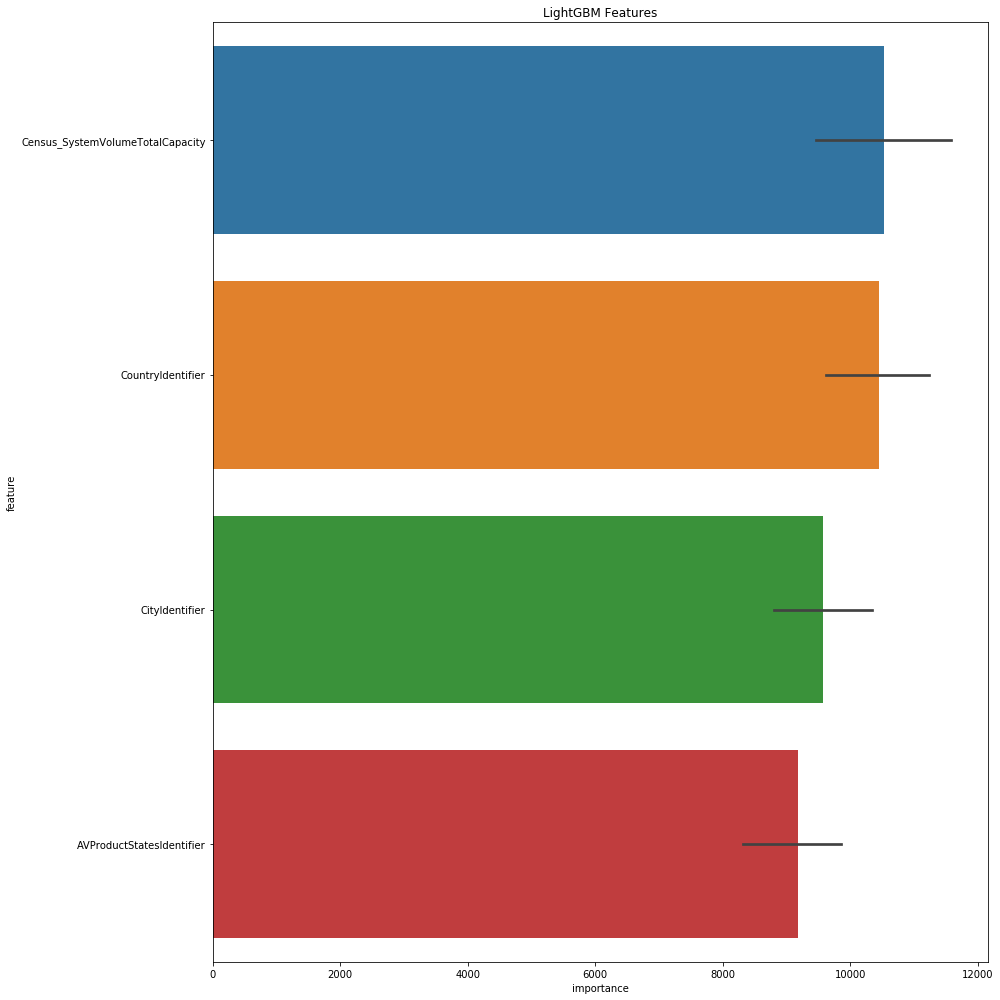

In [0]:
print('Full AUC score %.6f' % roc_auc_score(labels, oofPreds))

# Feature Importance
displayImportances(featureImportanceDf, submissionFileName)

In [0]:
kaggleSubmission = pd.read_csv(dataFolder + 'sample_submission.csv.zip')
kaggleSubmission['HasDetections'] = subPreds
kaggleSubmission.to_csv(submissionFileName + '.csv', index = False)

In [0]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'submission.csv'})
uploaded.SetContentFile('submission.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 11uU2B6slJAjXexc03t81A-JaC2KOTC8-


Score of .604 - when considered the max was ~.7 the performance is good, considering how few features! 

# Now Trying with 5 features

In [0]:
#vars
dataFolder = '/content/'
submissionFileName = 'submission1'
trainFile='train.csv.zip'
testFile='test.csv.zip'
#used 4000000 nr of rows in stead of 8000000 because of Kernel memory issue
numberOfRows = 2500000

In [0]:
seed = 6001
np.random.seed(seed)
random.seed(seed)

In [0]:
def displayImportances(featureImportanceDf, submissionFileName):
    cols = featureImportanceDf[["feature", "importance"]].groupby("feature").mean().sort_values(by = "importance", ascending = False).index
    bestFeatures = featureImportanceDf.loc[featureImportanceDf.feature.isin(cols)]
    plot.figure(figsize = (14, 14))
    sb.barplot(x = "importance", y = "feature", data = bestFeatures.sort_values(by = "importance", ascending = False))
    plot.title('LightGBM Features')
    plot.tight_layout()
    plot.savefig(submissionFileName + '.png')

In [0]:
dtypes = {
        'MachineIdentifier':                                    'category',
        'ProductName':                                          'category',
        'EngineVersion':                                        'category',
        'AppVersion':                                           'category',
        'AvSigVersion':                                         'category',
        'IsBeta':                                               'int8',
        'RtpStateBitfield':                                     'float16',
        'IsSxsPassiveMode':                                     'int8',
        'DefaultBrowsersIdentifier':                            'float16',
        'AVProductStatesIdentifier':                            'float32',
        'AVProductsInstalled':                                  'float16',
        'AVProductsEnabled':                                    'float16',
        'HasTpm':                                               'int8',
        'CountryIdentifier':                                    'int16',
        'CityIdentifier':                                       'float32',
        'OrganizationIdentifier':                               'float16',
        'GeoNameIdentifier':                                    'float16',
        'LocaleEnglishNameIdentifier':                          'int8',
        'Platform':                                             'category',
        'Processor':                                            'category',
        'OsVer':                                                'category',
        'OsBuild':                                              'int16',
        'OsSuite':                                              'int16',
        'OsPlatformSubRelease':                                 'category',
        'OsBuildLab':                                           'category',
        'SkuEdition':                                           'category',
        'IsProtected':                                          'float16',
        'AutoSampleOptIn':                                      'int8',
        'PuaMode':                                              'category',
        'SMode':                                                'float16',
        'IeVerIdentifier':                                      'float16',
        'SmartScreen':                                          'category',
        'Firewall':                                             'float16',
        'UacLuaenable':                                         'float32',
        'Census_MDC2FormFactor':                                'category',
        'Census_DeviceFamily':                                  'category',
        'Census_OEMNameIdentifier':                             'float16',
        'Census_OEMModelIdentifier':                            'float32',
        'Census_ProcessorCoreCount':                            'float16',
        'Census_ProcessorManufacturerIdentifier':               'float16',
        'Census_ProcessorModelIdentifier':                      'float16',
        'Census_ProcessorClass':                                'category',
        'Census_PrimaryDiskTotalCapacity':                      'float32',
        'Census_PrimaryDiskTypeName':                           'category',
        'Census_SystemVolumeTotalCapacity':                     'float32',
        'Census_HasOpticalDiskDrive':                           'int8',
        'Census_TotalPhysicalRAM':                              'float32',
        'Census_ChassisTypeName':                               'category',
        'Census_InternalPrimaryDiagonalDisplaySizeInInches':    'float16',
        'Census_InternalPrimaryDisplayResolutionHorizontal':    'float16',
        'Census_InternalPrimaryDisplayResolutionVertical':      'float16',
        'Census_PowerPlatformRoleName':                         'category',
        'Census_InternalBatteryType':                           'category',
        'Census_InternalBatteryNumberOfCharges':                'float32',
        'Census_OSVersion':                                     'category',
        'Census_OSArchitecture':                                'category',
        'Census_OSBranch':                                      'category',
        'Census_OSBuildNumber':                                 'int16',
        'Census_OSBuildRevision':                               'int32',
        'Census_OSEdition':                                     'category',
        'Census_OSSkuName':                                     'category',
        'Census_OSInstallTypeName':                             'category',
        'Census_OSInstallLanguageIdentifier':                   'float16',
        'Census_OSUILocaleIdentifier':                          'int16',
        'Census_OSWUAutoUpdateOptionsName':                     'category',
        'Census_IsPortableOperatingSystem':                     'int8',
        'Census_GenuineStateName':                              'category',
        'Census_ActivationChannel':                             'category',
        'Census_IsFlightingInternal':                           'float16',
        'Census_IsFlightsDisabled':                             'float16',
        'Census_FlightRing':                                    'category',
        'Census_ThresholdOptIn':                                'float16',
        'Census_FirmwareManufacturerIdentifier':                'float16',
        'Census_FirmwareVersionIdentifier':                     'float32',
        'Census_IsSecureBootEnabled':                           'int8',
        'Census_IsWIMBootEnabled':                              'float16',
        'Census_IsVirtualDevice':                               'float16',
        'Census_IsTouchEnabled':                                'int8',
        'Census_IsPenCapable':                                  'int8',
        'Census_IsAlwaysOnAlwaysConnectedCapable':              'float16',
        'Wdft_IsGamer':                                         'float16',
        'Wdft_RegionIdentifier':                                'float16',
        'HasDetections':                                        'int8'
        }

selectedFeatures = [  
    'CountryIdentifier',                                  
    'CityIdentifier',                                      
    'Census_OSVersion',                                        
    'Census_SystemVolumeTotalCapacity', 
    'AVProductStatesIdentifier'
    ]

In [0]:
trainDf = pd.read_csv(dataFolder + trainFile, dtype=dtypes, usecols=selectedFeatures, low_memory=True, nrows = numberOfRows)
labels = pd.read_csv(dataFolder + trainFile, usecols = ['HasDetections'], nrows = numberOfRows)
testDf = pd.read_csv(dataFolder + testFile, dtype=dtypes, usecols=selectedFeatures, low_memory=True)
print('== Dataset Shapes ==')
print('Train : ' + str(trainDf.shape))
print('Labels : ' + str(labels.shape))
print('Test : ' + str(testDf.shape))

== Dataset Shapes ==
Train : (2500000, 5)
Labels : (2500000, 1)
Test : (7853253, 5)


In [0]:
# Append Datasets and Cleanup
df = trainDf.append(testDf).reset_index()
del trainDf, testDf
gc.collect()

11457

In [0]:
#Count Encoding (with exceptions)
for col in [f for f in df.columns if f not in ['index','HasDetections','Census_SystemVolumeTotalCapacity']]:
    df[col]=df[col].map(df[col].value_counts())

dfDummy = pd.get_dummies(df, dummy_na=True)
print('Dummy: ' + str(dfDummy.shape))

# Cleanup
del df
gc.collect()

Dummy: (10353253, 6)


64

In [0]:
# Split back to train and test
train = dfDummy[:numberOfRows]
test = dfDummy[numberOfRows:]

# Cleanup
del dfDummy
gc.collect()

# Summary Shape
print('== Dataset Shapes ==')
print('Train: ' + str(train.shape))
print('Test: ' + str(test.shape))

# Summary Columns
print('== Dataset Columns ==')
features = [f for f in train.columns if f not in ['index']]
for feature in features:
    print(feature)

== Dataset Shapes ==
Train: (2500000, 6)
Test: (7853253, 6)
== Dataset Columns ==
AVProductStatesIdentifier
CountryIdentifier
CityIdentifier
Census_SystemVolumeTotalCapacity
Census_OSVersion


In [0]:
# CV Folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = seed)

# Create arrays and dataframes to store results
oofPreds = np.zeros(train.shape[0])
subPreds = np.zeros(test.shape[0])
featureImportanceDf = pd.DataFrame()

# Loop through all Folds.
for n_fold, (trainXId, validXId) in enumerate(folds.split(train[features], labels)):
    # Create TrainXY and ValidationXY set based on fold-indexes
    trainX, trainY = train[features].iloc[trainXId], labels.iloc[trainXId]
    validX, validY = train[features].iloc[validXId], labels.iloc[validXId]

    print('== Fold: ' + str(n_fold))

    # LightGBM parameters
    lgbm = LGBMClassifier(
        objective = 'binary',
        boosting_type = 'gbdt',
        n_estimators = 2500,
        learning_rate = 0.1, 
        num_leaves = 200,
        min_data_in_leaf = 125, 
        bagging_fraction = 0.901,
        max_depth = 13, 
        reg_alpha = 2.5,
        reg_lambda = 2.5,
        min_split_gain = 0.0001,
        min_child_weight = 25,
        feature_fraction = 0.5, 
        silent = -1,
        verbose = -1,
        #n_jobs is set to -1 instead of 4 otherwise the kernell will time out
        n_jobs = 4) 

    lgbm.fit(trainX, trainY, 
        eval_set=[(trainX, trainY), (validX, validY)], 
        eval_metric = 'auc', 
        verbose = 100, 
        early_stopping_rounds = 125)

    oofPreds[validXId] = lgbm.predict_proba(validX, num_iteration = lgbm.best_iteration_)[:, 1]
    
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(validY, oofPreds[validXId])))
    
    # cleanup
    print('Cleanup')
    del trainX, trainY, validX, validY
    gc.collect()

    subPreds += lgbm.predict_proba(test[features], num_iteration = lgbm.best_iteration_)[:, 1] / folds.n_splits
        
    # Feature Importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = lgbm.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    featureImportanceDf = pd.concat([featureImportanceDf, fold_importance_df], axis=0)
        
    # cleanup
    print('Cleanup. Post-Fold')
    del lgbm
    gc.collect()

== Fold: 0


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 125 rounds.
[100]	training's binary_logloss: 0.657776	training's auc: 0.649102	valid_1's binary_logloss: 0.659929	valid_1's auc: 0.644067
[200]	training's binary_logloss: 0.654321	training's auc: 0.654984	valid_1's binary_logloss: 0.658474	valid_1's auc: 0.646198
[300]	training's binary_logloss: 0.652452	training's auc: 0.658426	valid_1's binary_logloss: 0.65817	valid_1's auc: 0.646679
[400]	training's binary_logloss: 0.650796	training's auc: 0.661458	valid_1's binary_logloss: 0.658034	valid_1's auc: 0.646838
[500]	training's binary_logloss: 0.649411	training's auc: 0.663923	valid_1's binary_logloss: 0.658015	valid_1's auc: 0.646853
Early stopping, best iteration is:
[384]	training's binary_logloss: 0.651026	training's auc: 0.661028	valid_1's binary_logloss: 0.658017	valid_1's auc: 0.646903
Fold  1 AUC : 0.646903
Cleanup
Cleanup. Post-Fold
== Fold: 1


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 125 rounds.
[100]	training's binary_logloss: 0.657802	training's auc: 0.649075	valid_1's binary_logloss: 0.660149	valid_1's auc: 0.643901
[200]	training's binary_logloss: 0.654419	training's auc: 0.654847	valid_1's binary_logloss: 0.658584	valid_1's auc: 0.646308
[300]	training's binary_logloss: 0.652493	training's auc: 0.658378	valid_1's binary_logloss: 0.658237	valid_1's auc: 0.64691
[400]	training's binary_logloss: 0.65093	training's auc: 0.661246	valid_1's binary_logloss: 0.658053	valid_1's auc: 0.647237
[500]	training's binary_logloss: 0.64953	training's auc: 0.663724	valid_1's binary_logloss: 0.658027	valid_1's auc: 0.647304
Early stopping, best iteration is:
[460]	training's binary_logloss: 0.650077	training's auc: 0.662718	valid_1's binary_logloss: 0.658003	valid_1's auc: 0.647329
Fold  2 AUC : 0.647329
Cleanup
Cleanup. Post-Fold
== Fold: 2


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 125 rounds.
[100]	training's binary_logloss: 0.657805	training's auc: 0.649016	valid_1's binary_logloss: 0.660361	valid_1's auc: 0.643427
[200]	training's binary_logloss: 0.654476	training's auc: 0.654683	valid_1's binary_logloss: 0.658875	valid_1's auc: 0.645785
[300]	training's binary_logloss: 0.652438	training's auc: 0.658433	valid_1's binary_logloss: 0.658459	valid_1's auc: 0.646504
[400]	training's binary_logloss: 0.650792	training's auc: 0.661425	valid_1's binary_logloss: 0.658266	valid_1's auc: 0.646831
[500]	training's binary_logloss: 0.649349	training's auc: 0.664022	valid_1's binary_logloss: 0.658169	valid_1's auc: 0.647074
[600]	training's binary_logloss: 0.648158	training's auc: 0.666133	valid_1's binary_logloss: 0.658199	valid_1's auc: 0.647044
Early stopping, best iteration is:
[535]	training's binary_logloss: 0.648936	training's auc: 0.664753	valid_1's binary_logloss: 0.65816	valid_1's auc: 0.647098
Fold  3 AUC : 0.64709

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 125 rounds.
[100]	training's binary_logloss: 0.657581	training's auc: 0.649477	valid_1's binary_logloss: 0.660584	valid_1's auc: 0.642898
[200]	training's binary_logloss: 0.654258	training's auc: 0.655158	valid_1's binary_logloss: 0.659099	valid_1's auc: 0.645373
[300]	training's binary_logloss: 0.652255	training's auc: 0.658782	valid_1's binary_logloss: 0.658734	valid_1's auc: 0.646015
[400]	training's binary_logloss: 0.650596	training's auc: 0.661807	valid_1's binary_logloss: 0.65857	valid_1's auc: 0.646314
[500]	training's binary_logloss: 0.649191	training's auc: 0.664298	valid_1's binary_logloss: 0.658537	valid_1's auc: 0.646412
[600]	training's binary_logloss: 0.648086	training's auc: 0.666266	valid_1's binary_logloss: 0.658582	valid_1's auc: 0.646371
Early stopping, best iteration is:
[481]	training's binary_logloss: 0.649444	training's auc: 0.663835	valid_1's binary_logloss: 0.658512	valid_1's auc: 0.646447
Fold  4 AUC : 0.64644

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 125 rounds.
[100]	training's binary_logloss: 0.657802	training's auc: 0.649123	valid_1's binary_logloss: 0.660278	valid_1's auc: 0.643606
[200]	training's binary_logloss: 0.654399	training's auc: 0.654903	valid_1's binary_logloss: 0.658804	valid_1's auc: 0.64588
[300]	training's binary_logloss: 0.652302	training's auc: 0.658794	valid_1's binary_logloss: 0.658446	valid_1's auc: 0.646478
[400]	training's binary_logloss: 0.65065	training's auc: 0.661782	valid_1's binary_logloss: 0.658295	valid_1's auc: 0.646727
[500]	training's binary_logloss: 0.649277	training's auc: 0.66424	valid_1's binary_logloss: 0.658292	valid_1's auc: 0.646715
Early stopping, best iteration is:
[461]	training's binary_logloss: 0.649792	training's auc: 0.663283	valid_1's binary_logloss: 0.658241	valid_1's auc: 0.646804
Fold  5 AUC : 0.646804
Cleanup
Cleanup. Post-Fold


Full AUC score 0.646915


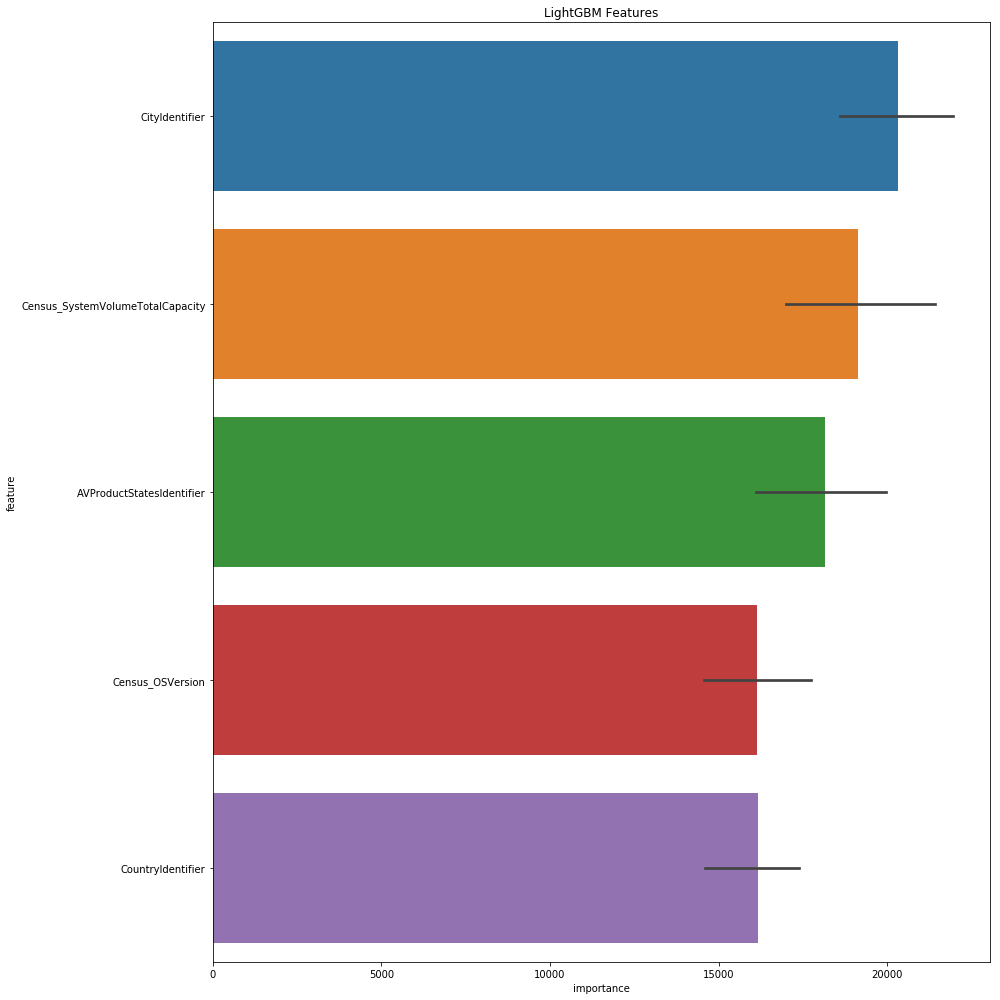

In [0]:
print('Full AUC score %.6f' % roc_auc_score(labels, oofPreds))

# Feature Importance
displayImportances(featureImportanceDf, submissionFileName)

In [0]:
kaggleSubmission = pd.read_csv(dataFolder + 'sample_submission.csv.zip')
kaggleSubmission['HasDetections'] = subPreds
kaggleSubmission.to_csv('ssubmission5lgbm' + '.csv', index = False)

In [0]:
!pip install pydrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': 'ssubmission5lgbm.csv'})
uploaded.SetContentFile('ssubmission5lgbm.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1fI4iGedIgYtI8gHwaiCte11sOFn4LERk


Increasing the number of features brought the public score up to 0.61585 but also greatly increased execution time